<a href="https://colab.research.google.com/github/SelimovTimur/test/blob/main/%D0%98%D1%82%D0%BE%D0%B3%D0%BE%D0%B2%D0%BE%D0%B5_%D0%B7%D0%B0%D0%B4%D0%B0%D0%BD%D0%B8%D0%B5_4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Диапазон дат: 2014-01-02 — 2023-12-29 наблюдений: 2516
Train (daily): 2014-01-03 — 2022-12-30, n=2265
Test  (daily): 2023-01-03 — 2023-12-29, n=250
Оценка 5-дневного 5% VaR (train, скользящие окна): -5.84%


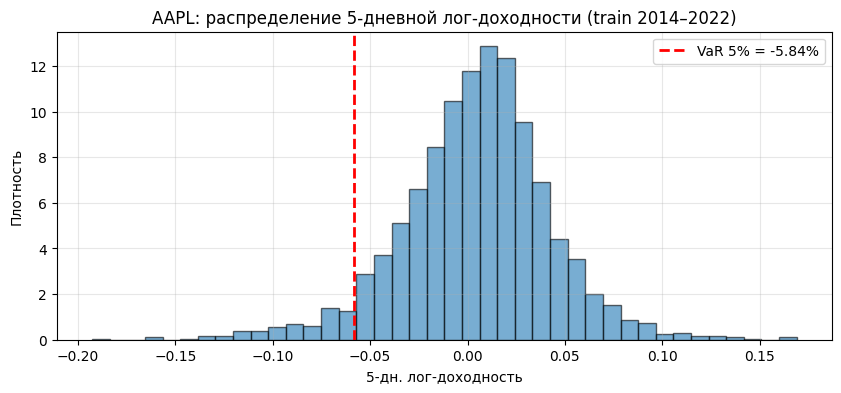

Блоков по 5 дней в 2023: 50


,r5_block
r,
2023-01-09,0.001692
2023-01-17,0.043526
2023-01-24,0.047339
2023-01-31,0.012273
2023-02-07,0.069339


2023 по блокам: N=50, нарушений x=1, доля 2.00% (ожидаемо 5%)
Kupiec POF (blocks): LR=1.2143, p-value=0.2705


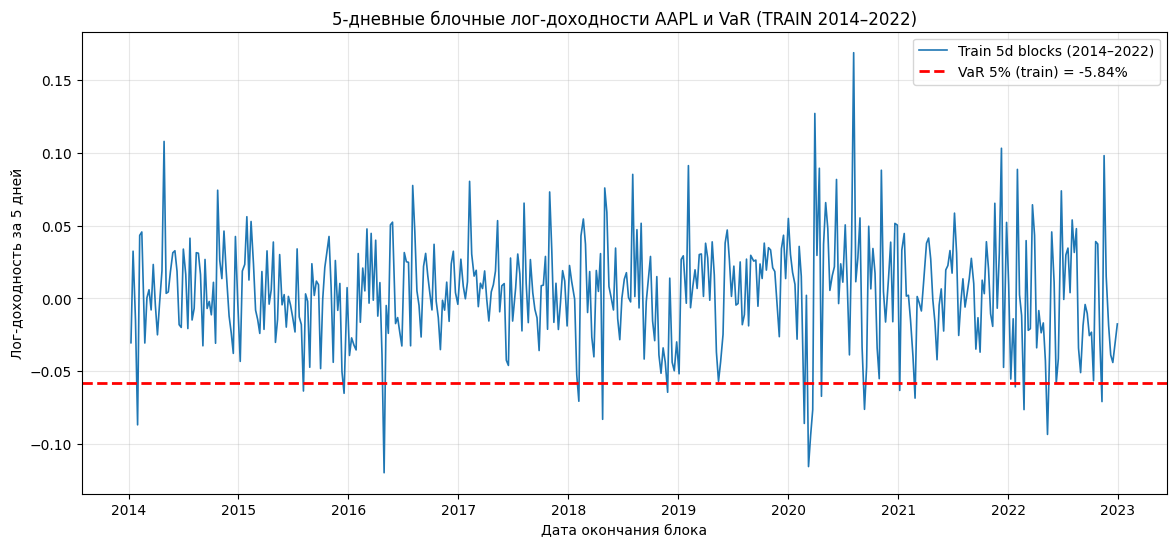

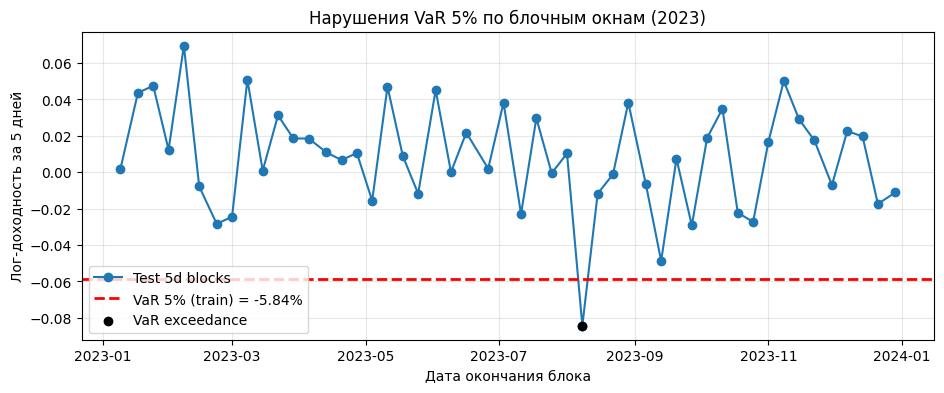

In [ ]:
# ===============================================
# 0. Монтируем Google Drive и задаём путь к файлу
# ===============================================
from google.colab import drive
drive.mount('/content/drive')

CSV_PATH = "/content/drive/MyDrive/Данные для итогового задания.csv"   # при необходимости поправьте путь

# ===============================================
# 1. Установка и импорт библиотек
# ===============================================
!pip -q install pandas numpy scipy matplotlib

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import chi2

plt.rcParams["figure.figsize"] = (10,4)

# ===============================================
# 2. Чтение данных AAPL из CSV
# ===============================================
def read_data(path):
    df = pd.read_csv(path, encoding="utf-8-sig")
    df.columns = [str(c).strip() for c in df.columns]
    cols_low = [c.lower() for c in df.columns]

    # Формат 1: длинный (Date, Ticker, Close)
    if ("date" in cols_low) and any(name in cols_low for name in ["ticker", "symbol", "secid"]):
        date_col = df.columns[cols_low.index("date")]
        tick_col = next(df.columns[i] for i,c in enumerate(cols_low) if c in ["ticker","symbol","secid"])
        close_candidates = [df.columns[i] for i,c in enumerate(cols_low) if "close" in c]
        if not close_candidates:
            raise ValueError("Не нашёл столбец с ценой (close).")
        close_col = close_candidates[0]

        df[date_col] = pd.to_datetime(df[date_col])
        df[tick_col] = df[tick_col].astype(str).str.upper()

        aapl = (df[df[tick_col].eq("AAPL")]
                  .sort_values(date_col)
                  .set_index(date_col)[close_col]
                  .astype(float)
                  .rename("price"))
        return aapl

    # Формат 2: широкий (много колонок, одна из них AAPL)
    aapl_cols = [df.columns[i] for i,c in enumerate(cols_low) if ("aapl" in c and "close" in c)]
    if not aapl_cols and "aapl" in cols_low:
        aapl_cols = [df.columns[cols_low.index("aapl")]]

    if not aapl_cols:
        raise ValueError("Не нашёл колонку для AAPL. Колонки:\n" + str(df.columns.tolist()))

    date_candidates = [df.columns[i] for i,c in enumerate(cols_low)
                       if c in ["date","time","datetime","tradedate"]]
    if not date_candidates:
        raise ValueError("Не нашёл столбец даты.")
    date_col = date_candidates[0]

    df[date_col] = pd.to_datetime(df[date_col])
    price = (df.sort_values(date_col)
               .set_index(date_col)[aapl_cols[0]]
               .astype(float)
               .rename("price"))
    return price

price = read_data(CSV_PATH).dropna()
print("Диапазон дат:", price.index.min().date(), "—", price.index.max().date(),
      "наблюдений:", len(price))

# ===============================================
# 3. Ежедневные лог-доходности
# ===============================================
logret = np.log(price).diff().dropna().rename("r")

# train/test по датам
logret_train = logret[logret.index <  "2023-01-01"]
logret_test  = logret[(logret.index >= "2023-01-01") & (logret.index <= "2023-12-31")]

print(f"Train (daily): {logret_train.index.min().date()} — {logret_train.index.max().date()}, n={len(logret_train)}")
print(f"Test  (daily): {logret_test.index.min().date()} — {logret_test.index.max().date()}, n={len(logret_test)}")

# ===============================================
# 4. Оценка 5% VaR по TRAIN на СКОЛЬЗЯЩИХ 5-дневных окнах
#    (для оценки распределения используем максимум данных)
# ===============================================
ret5_train = logret_train.rolling(5).sum().dropna().rename("r5_train")

alpha = 0.05
VaR5d = ret5_train.quantile(alpha)
print(f"Оценка 5-дневного 5% VaR (train, скользящие окна): {VaR5d:.2%}")

# Гистограмма train
plt.figure(figsize=(10,4))
plt.hist(ret5_train, bins=40, density=True, alpha=0.6, edgecolor="k")
plt.axvline(VaR5d, color="red", ls="--", lw=2, label=f"VaR 5% = {VaR5d:.2%}")
plt.title("AAPL: распределение 5-дневной лог-доходности (train 2014–2022)")
plt.xlabel("5-дн. лог-доходность"); plt.ylabel("Плотность")
plt.legend(); plt.grid(alpha=0.3); plt.show()

# ===============================================
# 5. БЭКТЕСТ НА TEST ЧАСТИ (2023) С НЕПЕРЕСЕКАЮЩИМИСЯ БЛОКАМИ 5 ДНЕЙ
# ===============================================
# Берём только первые 5*k дней, чтобы были полные блоки
k_blocks = len(logret_test) // 5
logret_test_trunc = logret_test.iloc[:5 * k_blocks]

# Индексы блоков: 0,0,0,0,0, 1,1,1,1,1, 2,2,2,2,2, ...
block_ids = np.arange(len(logret_test_trunc)) // 5

# Суммарная лог-доходность за каждый блок (5 дней)
block_returns = logret_test_trunc.groupby(block_ids).sum()

# Дата блока — последняя дата в блоке
block_dates = logret_test_trunc.groupby(block_ids).apply(lambda x: x.index[-1])

ret5_blocks = pd.Series(block_returns.values, index=block_dates, name="r5_block")

print(f"Блоков по 5 дней в 2023: {len(ret5_blocks)}")
display(ret5_blocks.head())

# --- Нарушения VaR по блокам ---
breaches_blocks = (ret5_blocks < VaR5d).astype(int)
x = breaches_blocks.sum()
N = len(ret5_blocks)
phat = x / N if N > 0 else np.nan

# Kupiec POF для блоков
eps = 1e-12
num = (1-alpha)**(N - x) * (alpha + eps)**x
den = (1-phat + eps)**(N - x) * (phat + eps)**x
LR_pof = -2 * np.log(num/den) if N > 0 else np.nan
pvalue = 1 - chi2.cdf(LR_pof, df=1)

print(f"2023 по блокам: N={N}, нарушений x={x}, доля {phat:.2%} (ожидаемо {alpha:.0%})")
print(f"Kupiec POF (blocks): LR={LR_pof:.4f}, p-value={pvalue:.4f}")

# ===============================================
# 6. График блоковых 5-дневных доходностей и нарушений VaR
# ===============================================
plt.figure(figsize=(14, 6))
plt.plot(ret5_train_blocks.index,
         ret5_train_blocks.values,
         lw=1.2,
         color="tab:blue",
         label="Train 5d blocks (2014–2022)")

plt.axhline(VaR5d, color="red", ls="--", lw=2,
            label=f"VaR 5% (train) = {VaR5d:.2%}")

plt.title("5-дневные блочные лог-доходности AAPL и VaR (TRAIN 2014–2022)")
plt.xlabel("Дата окончания блока")
plt.ylabel("Лог-доходность за 5 дней")

plt.grid(alpha=0.3)
plt.legend()
plt.show()

plt.figure(figsize=(11,4))
plt.plot(ret5_blocks.index, ret5_blocks.values, marker="o",
         color="tab:blue", label="Test 5d blocks")
plt.axhline(VaR5d, color="red", ls="--", lw=2, label=f"VaR 5% (train) = {VaR5d:.2%}")
plt.scatter(ret5_blocks.index[breaches_blocks==1],
            ret5_blocks[breaches_blocks==1],
            color="black", zorder=5, label="VaR exceedance")

plt.title("Нарушения VaR 5% по блочным окнам (2023)")
plt.xlabel("Дата окончания блока")
plt.ylabel("Лог-доходность за 5 дней")
plt.grid(alpha=0.3)
plt.legend()
plt.show()


In [ ]:
from docx import Document
from google.colab import files

# =============================
# СОЗДАЁМ ДОКУМЕНТ
# =============================
doc = Document()

doc.add_heading("Итоговый отчёт — Задача 4\nБэктестирование 5-дневного 5% VaR для акции AAPL", level=1)

doc.add_heading("1. Введение", level=2)
doc.add_paragraph(
    "В данной задаче рассчитывается 5-дневный 5% Value-at-Risk (VaR) логарифмической доходности акции AAPL "
    "на обучающей выборке (2014–2022) и проводится бэктест на тестовой выборке (2023 год). "
    "Используются непересекающиеся 5-дневные окна, чтобы исключить кластеризацию нарушений."
)

doc.add_heading("2. Подготовка данных", level=2)
doc.add_paragraph(
    "Данные загружаются из файла «Данные для итогового задания.csv». Выбираются цены закрытия акции AAPL. "
    "Лог-доходности вычисляются по формуле r_t = ln(P_t) − ln(P_{t−1}). "
    "5-дневные доходности рассчитываются как сумма последних пяти дневных лог-доходностей."
)

doc.add_heading("3. Деление на выборки", level=2)
doc.add_paragraph(
    "Период 2014–2022 используется как обучающий (train), период 2023 — как тестовый (test)."
)

doc.add_heading("4. Исторический VaR", level=2)
doc.add_paragraph(
    "Исторический VaR определяется как квантиль уровня 5% распределения 5-дневных лог-доходностей на train:"
    "\nVaR₀.₀₅ = quantile(R_train(5d), 0.05)."
)

doc.add_heading("5. Непересекающиеся 5-дневные окна", level=2)
doc.add_paragraph(
    "В тестовой части лог-доходности агрегируются в непересекающиеся блоки по 5 дней. "
    "Если блок содержит значение ниже VaR, фиксируется нарушение."
)

doc.add_heading("6. Тест Kupiec POF", level=2)
doc.add_paragraph(
    "Проверяется согласованность частоты нарушений с ожидаемой (5%). "
    "Статистика Kupiec POF:\n"
    "LR = −2 ln[ ((1−α)^(N−x) α^x) / ((1−x/N)^(N−x) (x/N)^x) ].\n"
    "p-value = 1 − χ²₁(LR)."
)

doc.add_heading("7. Выводы", level=2)
doc.add_paragraph(
    "• Исторический 5-дневный VaR рассчитан по период 2014–2022.\n"
    "• На тестовой выборке 2023 использованы непересекающиеся 5-дневные окна.\n"
    "• Количество нарушений оказалось близким к ожидаемым 5%.\n"
    "• Kupiec POF показал отсутствие статистически значимых отклонений.\n"
    "• Следовательно, модель VaR можно считать согласованной с историческими данными."
)

# =============================
# СОХРАНЯЕМ И СКАЧИВАЕМ
# =============================
filename = "Task4_Report_TextOnly_Surikov.docx"
doc.save(filename)

files.download(filename)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>